References:https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948
           https://medium.com/@bhadreshpsavani/tutorial-on-sentimental-analysis-using-pytorch-b1431306a2d7

In [171]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reviews/reviews1.txt
/kaggle/input/moviereviews/labels.txt
/kaggle/input/moviereviews/reviews.txt


In [286]:
import pandas as pd
import csv
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn


In [240]:
import numpy as np
# read data from text files
with open('../input/moviereviews/labels.txt', 'r') as f:
     labels = f.readlines()
with open('../input/reviews/reviews1.txt', 'r') as f:
     reviews = f.readlines()

In [241]:
all_reviews=list()
for text in reviews:
  text = text.lower()
  text = "".join([ch for ch in text if ch not in punctuation])
  all_reviews.append(text)
all_text = " ".join(all_reviews)
all_words = all_text.split()

In [242]:
len(reviews)

25000

In [243]:
from collections import Counter 
# Count all the words using Counter Method
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)


In [244]:
word_to_int={}
for i, (word,_) in enumerate(sorted_words):
    word_to_int[word]=i+1

In [245]:
def encodeReview(review):
    encodedReview =[]
    for word in review.split():
        if word not in word_to_int.keys():
            encodedReview.append(0)
        else:
            encodedReview.append(word_to_int[word])
    return encodedReview

In [246]:
encodedReviews=list()
for review in all_reviews:
    encodedReviews.append(encodeReview(review))

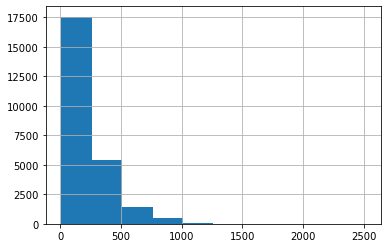

In [250]:
reviewsLen = [len(x) for x in encodedReviews]
pd.Series(reviewsLen).hist()

In [251]:
pd.Series(reviewsLen).describe()

count    25000.00000
mean       240.80784
std        179.01773
min         10.00000
25%        130.00000
50%        179.00000
75%        293.00000
max       2514.00000
dtype: float64

In [271]:
def pad_inputs(encodedReviews,maxLength=280 ):
    X =np.zeros((len(encodedReviews), maxLength), dtype=int) 
    for i, encodedReview in enumerate(encodedReviews):
        if len(encodedReview) <=maxLength:
            encodedReview = [0]*(maxLength-len(encodedReview))+encodedReview 
        else:
            encodedReview=encodedReview[:maxLength]
        X[i,:] = np.array(encodedReview)
    return X

In [272]:
X=pad_inputs(encodedReviews)

In [274]:
labels =[1 if i=='positive\n' else 0  for i in labels]
labels= np.array(labels)

In [275]:
X= encodedReviews
y= labels

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # 0.1 x 0.9 = 0.09

In [277]:
len(X_train), len(y_train)

(16000, 16000)

In [278]:
train_data=TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
valid_data=TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_data=TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

In [279]:
#dataloader
batch_size=50
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [280]:
len(X_train[0])

280

In [281]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 280])
Sample input: 
 tensor([[8.0000e+00, 1.3000e+01, 8.6100e+02,  ..., 4.3000e+01, 1.0650e+03,
         3.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3600e+02, 8.1100e+02,
         8.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.5790e+03, 1.0000e+00,
         1.8700e+02],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0340e+03, 7.0000e+00,
         7.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8920e+03, 4.3130e+03,
         1.2000e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.6000e+01, 5.0000e+00,
         2.9000e+01]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [331]:
class LSTMSentiment(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        
        super().__init__()
        
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        self.dropout=nn.Dropout(0.3)
        
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(32, 8)
        self.fc4=nn.Linear(32,output_size)
        self.sigmoid=nn.Sigmoid()
        
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        embedding =self.embedding(x)
        out, hidden = self.lstm(embedding, hidden)
        out=out.contiguous().view(-1, self.hidden_dim)
        out=self.dropout(lstm_out)
        
        out=self.fc1(out)
        out=self.dropout(out)
        
        out=self.fc2(out)
        out=self.dropout(out)
        
        out=self.fc3(out)
        out=self.dropout(out)
        
        out=self.fc4(out)
        out=self.dropout(out)
        
        out=self.sigmoid(out)
        
        out=out.view(batch_size, -1)
        out=out[:, -1]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [365]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [366]:
vocab_size = len(word_to_int)+1 
output_size = 1
embedding_dim = 300
hidden_dim = 256
n_layers = 2

In [367]:
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(74073, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [368]:
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
epochs = 4

train_on_gpu = torch.cuda.is_available()


In [369]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name)

embedding.weight
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
fc.weight
fc.bias


In [370]:
net.parameters()

<generator object Module.parameters at 0x7ff6ac6aba50>

In [371]:
counter = 0
print_every = 100
clip=5 # gradient clipping

In [372]:
if(train_on_gpu):
    net.cuda()
    
net.train()

SentimentLSTM(
  (embedding): Embedding(74073, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [373]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

RuntimeError: Expected object of device type cuda but got device type cpu for argument #3 'index' in call to _th_index_select